In [41]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [42]:
def f(x):
    return 3*x**2 - 4*x + 5

In [43]:
f(3.0)

20.0

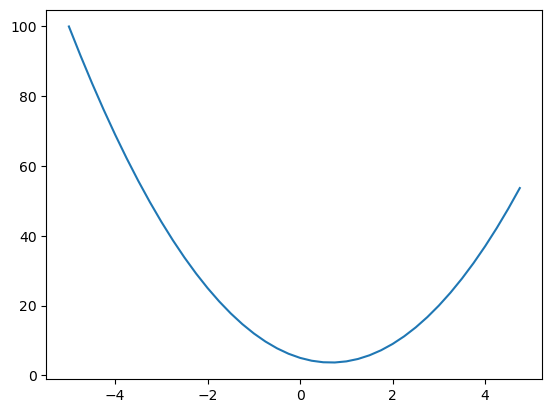

In [44]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys);

In [45]:
h = 0.00001
x = 2/3
(f(x + h) - f(x))/h

3.0000002482211127e-05

In [46]:
# les get more complex
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [47]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h)

d1 4.0
d2 4.0001
slope 0.9999999999976694


In [84]:
class Value:
  
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"
  
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward
        return out
    
    def __radd__(self, other):
        return self + other
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
    
    def __rsub__(self, other):
        return other + -(self)

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += out.grad * other.data
            other.grad += out.grad * self.data
            
        out._backward = _backward
        return out
    
    def __rmul__(self, other):
        return self * other
    
    def __pow__(self, other):
        assert isinstance(other, (int, float))
        
        out = Value(self.data ** other, (self, ), f'**{other}')
        
        def _backward():
            self.grad += out.grad * other * self.data ** (other-1)
        out._backward = _backward    
        return out
      
    def __truediv__(self, other):
        return self * other**-1
    
    def __rtruediv__(self, other):
        return other * self**-1
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out
    
    def relu(self):
        out = Value(max(0, self.data), (self, ), 'relu')
        def _backward():
            self.grad = (out.data > 0) * out.grad
        
        out._backward = _backward
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        
        def _backward():
            self.grad = out.data * out.grad 
        out._backward = _backward
        return out
    
    def backward(self):
        self.graud = 1.0
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1
        for node in reversed(topo):
            node._backward()
    

In [49]:
a = Value(2.0)
6 + a
a - 10

Value(data=-8.0)

In [50]:
a = Value(2.0)
b = a - 10
b.backward()

In [51]:
a.grad

1.0

In [52]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [53]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(data=-8.0)

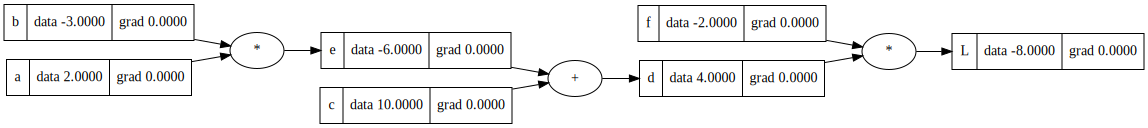

In [54]:
draw_dot(L)

In [55]:
L.grad = 1.0
d.grad = -2.0
f.grad = 4.0
e.grad = d.grad
c.grad = d.grad
b.grad = e.grad * 2.0
a.grad = e.grad * -3.0

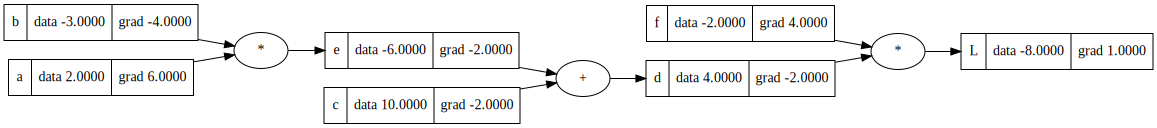

In [56]:
draw_dot(L)

In [57]:
# If we want grow up our function we should go in direction of gradiend
a.data += 0.001 * a.grad
b.data += 0.001 * b.grad

e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label ='L'
print(L)

Value(data=-7.947952000000001)


In [58]:
def lol():
    h = 0.1
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L.data
    print(L1)
    

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    b.data += h * b.grad
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L2 = L.data
    print(L2)
    
    return (L2 - L1)
lol()

-8.0
-8.0


0.0

In [59]:
def lol():
    h = 0.001
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L.data
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    f.data += h
    L = d * f; L.label = 'L'
    L2 = L.data
    return L2 - L1

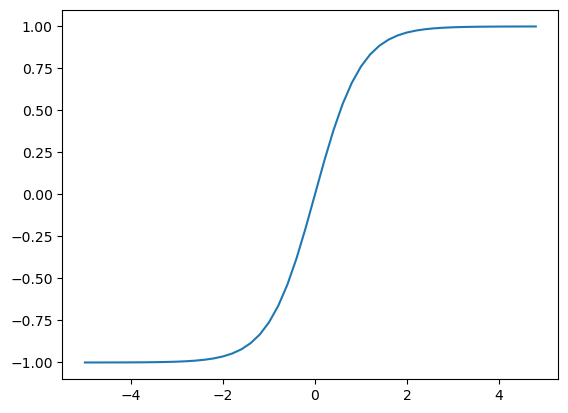

In [60]:
plt.plot(np.arange(-5, 5, 0.2), np.tanh(np.arange(-5, 5, 0.2)));

## Neuron backward

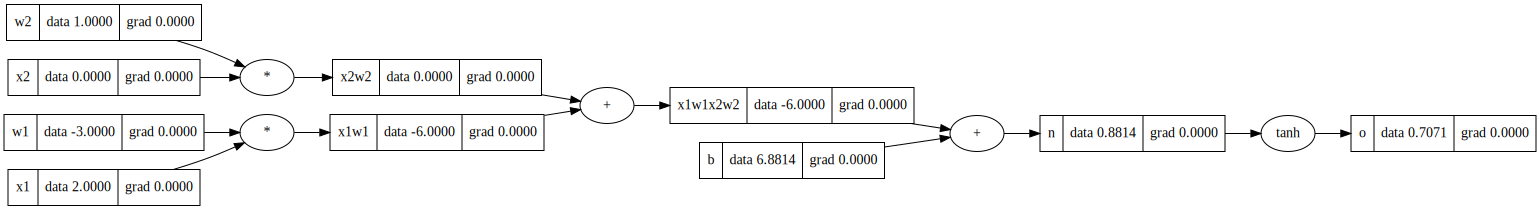

In [61]:
# inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# biases
b = Value(6.8813735870195432, label='b')

x1w1 = x1 * w1; x1w1.label='x1w1'
x2w2 = x2 * w2; x2w2.label='x2w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1x2w2'

# neuron
n = x1w1x2w2 + b; n.label='n'
o = n.tanh(); o.label='o'
draw_dot(o)

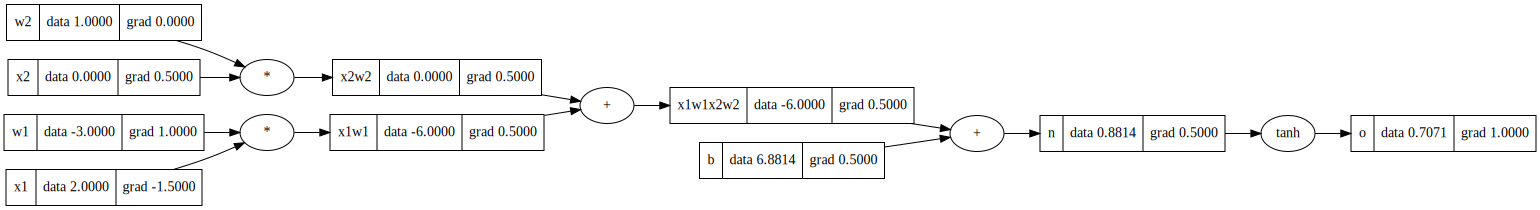

In [62]:
o.grad = 1.0
n.grad = 1.0 - o.data**2
b.grad = n.grad
x1w1x2w2.grad = n.grad
x2w2.grad = x1w1x2w2.grad
x1w1.grad = x1w1x2w2.grad

w1.grad = 2.0 * x1w1.grad
x1.grad = -3.0 * x1w1.grad

w2.grad = 0.0 * x2w2.grad
x2.grad = 1.0 * x2w2.grad

draw_dot(o)

### With backward()

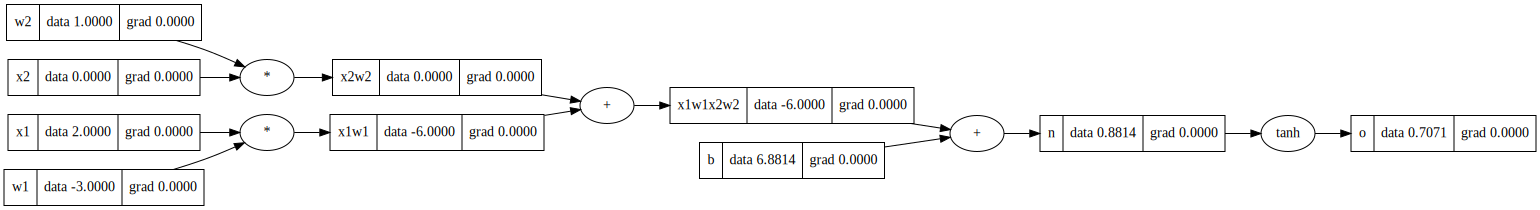

In [63]:
# inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# biases
b = Value(6.8813735870195432, label='b')

x1w1 = x1 * w1; x1w1.label='x1w1'
x2w2 = x2 * w2; x2w2.label='x2w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1x2w2'

# neuron
n = x1w1x2w2 + b; n.label='n'
o = n.tanh(); o.label='o'
# o.backward()
draw_dot(o)

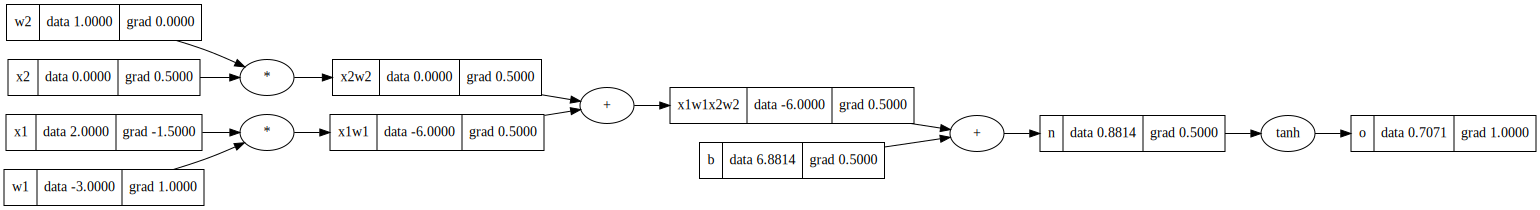

In [64]:
o.backward()
draw_dot(o)

In [65]:
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            print(v._prev)
            print(child.label)
            build_topo(child)
        topo.append(v)
build_topo(o)
# topo

for node in reversed(topo):
    node._backward()


{Value(data=0.8813735870195432)}
n
{Value(data=6.881373587019543), Value(data=-6.0)}
b
{Value(data=6.881373587019543), Value(data=-6.0)}
x1w1x2w2
{Value(data=-6.0), Value(data=0.0)}
x1w1
{Value(data=2.0), Value(data=-3.0)}
x1
{Value(data=2.0), Value(data=-3.0)}
w1
{Value(data=-6.0), Value(data=0.0)}
x2w2
{Value(data=1.0), Value(data=0.0)}
w2
{Value(data=1.0), Value(data=0.0)}
x2


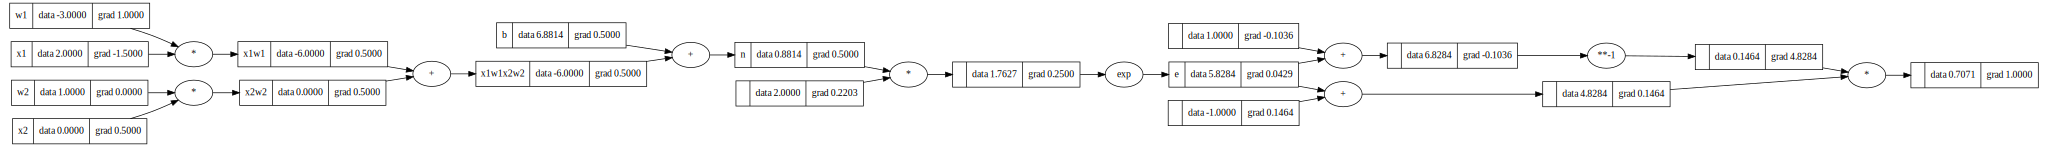

In [66]:
# inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# biases
b = Value(6.8813735870195432, label='b')

x1w1 = x1 * w1; x1w1.label='x1w1'
x2w2 = x2 * w2; x2w2.label='x2w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1x2w2'

# neuron
n = x1w1x2w2 + b; n.label='n'

# 
e = (n*2).exp(); e.label='e'
o = (e - 1) / (e + 1)

o.backward()
draw_dot(o)

# PyTorch

In [67]:
import torch
import random

In [68]:
x1 = torch.tensor([2.0]).double(); x1.requires_grad=True
x2 = torch.tensor([0.0]).double(); x2.requires_grad=True
w1 = torch.tensor([-3.0]).double(); w1.requires_grad=True
w2 = torch.tensor([1.0]).double(); w2.requires_grad=True
b = torch.tensor([6.8813735870195432]).double(); b.requires_grad=True
n = x1 * w1 + x2 * w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('--')
print('x1', x1.grad.item())
print('w1', w1.grad.item())
print('x2', x2.grad)
print('w2', w2.grad)

0.7071066904050358
--
x1 -1.5000003851533106
w1 1.0000002567688737
x2 tensor([0.5000], dtype=torch.float64)
w2 tensor([0.], dtype=torch.float64)


In [69]:
class Module:
    
    def zero_grad(self):
        for p in self.parameters():
            p.grad = 0
    
    def parameters(self):
        return []

class Neuron(Module):
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))
    
    def __call__(self, x):
        # w * x + b
        act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]

    
class Layer(Module):
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()]
    
    
class MLP(Module):
    def __init__(self, nin, nout):
        sz = [nin] + nout
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nout))]
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [70]:
x = [2.0, 3.0, 3.1, 1.0]
n = MLP(3, [4, 4, 1])

print('number of parameters: ', len(n.parameters()))
n(x)

number of parameters:  41


Value(data=-0.07308030971989815)

In [71]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets 

In [72]:
ypred = [n(x) for x in xs]

loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=3.960171345151203)

In [79]:
h = 0.001
for k in range(1000):
    
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))    
    
    # backard pass
    for p in n.parameters():
        p.grad = 0
    loss.backward()
    
    for p in n.parameters():
        p.data += -h * p.grad

    print(k, loss.data)

0 0.005104041700304906
1 0.005102938473674851
2 0.005101835703564899
3 0.005100733389697286
4 0.005099631531794479
5 0.005098530129579141
6 0.005097429182774204
7 0.005096328691102785
8 0.005095228654288204
9 0.005094129072054092
10 0.005093029944124195
11 0.0050919312702225284
12 0.005090833050073334
13 0.005089735283401074
14 0.00508863796993041
15 0.005087541109386251
16 0.005086444701493691
17 0.005085348745978095
18 0.0050842532425649685
19 0.0050831581909801275
20 0.005082063590949568
21 0.005080969442199481
22 0.005079875744456279
23 0.005078782497446661
24 0.005077689700897458
25 0.005076597354535745
26 0.005075505458088869
27 0.0050744140112842714
28 0.005073323013849777
29 0.005072232465513308
30 0.005071142366003025
31 0.005070052715047316
32 0.005068963512374802
33 0.005067874757714294
34 0.005066786450794834
35 0.005065698591345656
36 0.005064611179096265
37 0.005063524213776317
38 0.005062437695115721
39 0.0050613516228445905
40 0.005060265996693249
41 0.00505918081639223

335 0.0047583835779718454
336 0.004757419022898111
337 0.004756454842498608
338 0.0047554910365592345
339 0.004754527604866089
340 0.004753564547205349
341 0.004752601863363418
342 0.004751639553126849
343 0.004750677616282311
344 0.0047497160526166985
345 0.004748754861917019
346 0.00474779404397047
347 0.004746833598564401
348 0.004745873525486326
349 0.00474491382452388
350 0.004743954495464883
351 0.004742995538097359
352 0.00474203695220941
353 0.004741078737589357
354 0.004740120894025687
355 0.004739163421306973
356 0.004738206319222023
357 0.004737249587559744
358 0.004736293226109261
359 0.004735337234659831
360 0.004734381613000823
361 0.0047334263609218686
362 0.004732471478212642
363 0.004731516964663059
364 0.004730562820063168
365 0.00472960904420311
366 0.004728655636873317
367 0.004727702597864253
368 0.004726749926966626
369 0.004725797623971238
370 0.004724845688669078
371 0.0047238941208512745
372 0.004722942920309167
373 0.004721992086834158
374 0.004721041620217904

671 0.004454117400892012
672 0.004453267623810675
673 0.00445241815767615
674 0.004451569002320967
675 0.004450720157577798
676 0.004449871623279408
677 0.004449023399258696
678 0.004448175485348688
679 0.0044473278813825295
680 0.004446480587193446
681 0.004445633602614837
682 0.004444786927480191
683 0.004443940561623111
684 0.004443094504877315
685 0.004442248757076658
686 0.0044414033180551135
687 0.0044405581876467305
688 0.004439713365685726
689 0.004438868852006427
690 0.0044380246464432345
691 0.004437180748830742
692 0.004436337159003566
693 0.004435493876796516
694 0.004434650902044488
695 0.004433808234582518
696 0.004432965874245719
697 0.00443212382086933
698 0.0044312820742887634
699 0.004430440634339439
700 0.004429599500857022
701 0.004428758673677197
702 0.004427918152635759
703 0.004427077937568725
704 0.004426238028312125
705 0.004425398424702119
706 0.004424559126575051
707 0.004423720133767283
708 0.0044228814461153825
709 0.0044220430634559415
710 0.00442120498562

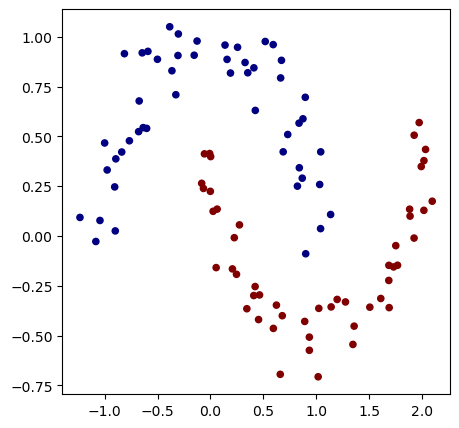

In [118]:
# make up a dataset

from sklearn.datasets import make_moons, make_blobs
X, y = make_moons(n_samples=100, noise=0.1)

y = y*2 - 1 # make y be -1 or 1
# visualize in 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

In [145]:
model = MLP(2, [16, 16, 1]) # 2-layer neural network
print(model)
print("number of parameters", len(model.parameters()))

number of parameters 337


In [144]:
def loss(batch_size=None):
    
    # inline DataLoader :)
    if batch_size is None:
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]
    inputs = [list(map(Value, xrow)) for xrow in Xb]
    
    # forward the model to get scores
    scores = list(map(model, inputs))
    
    # svm "max-margin" loss
    losses = [(1 + -yi*scorei).relu() for yi, scorei in zip(yb, scores)]
    data_loss = sum(losses) * (1.0 / len(losses))
    # L2 regularization
    alpha = 1e-4
    alpha = 1
    reg_loss = alpha * sum((p*p for p in model.parameters()))
    total_loss = data_loss + reg_loss
    total_loss = data_loss
    
    # also get accuracy
    accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]
    return total_loss, sum(accuracy) / len(accuracy)

total_loss, acc = loss()
print(total_loss, acc)

Value(data=0.42000611017327516) 0.79


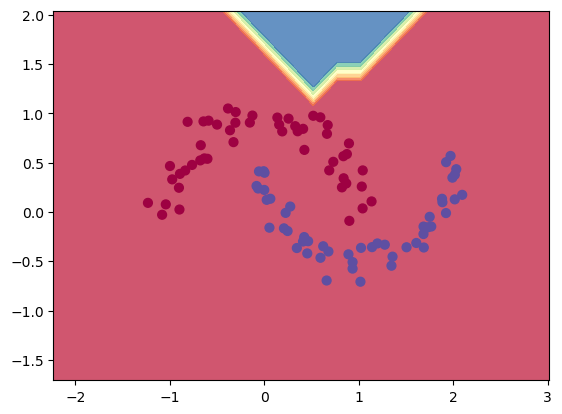

step 0 loss 1.4903074218532277, accuracy 22.0%


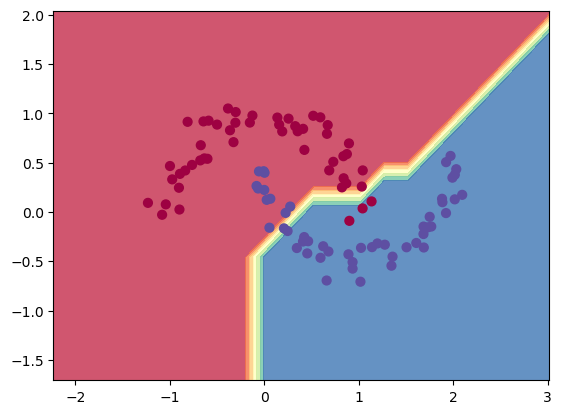

step 1 loss 0.9632048188215144, accuracy 50.0%


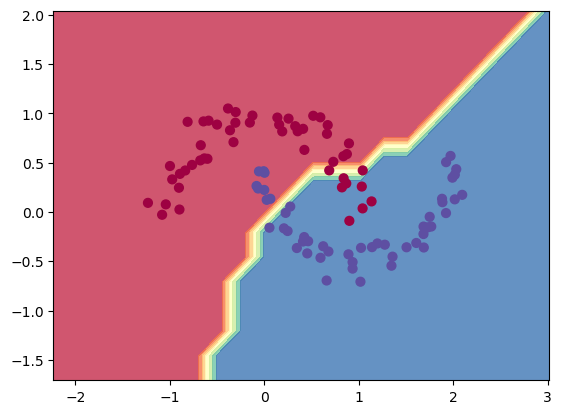

step 2 loss 0.42061306754423117, accuracy 85.0%


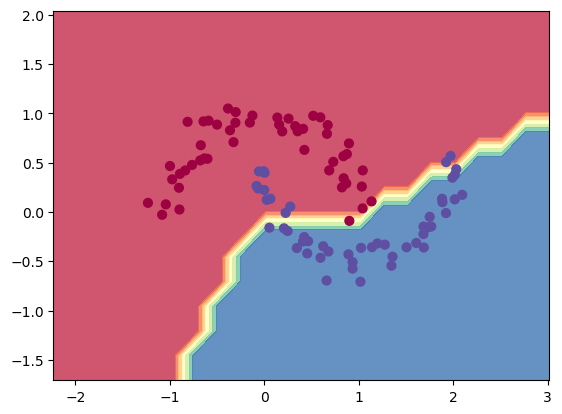

step 3 loss 0.3350937202360253, accuracy 84.0%


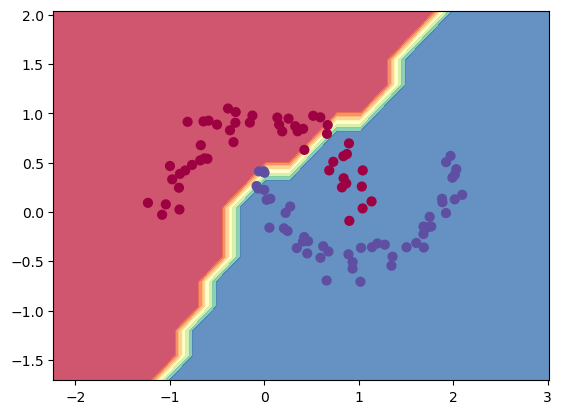

step 4 loss 0.3289298826952753, accuracy 88.0%


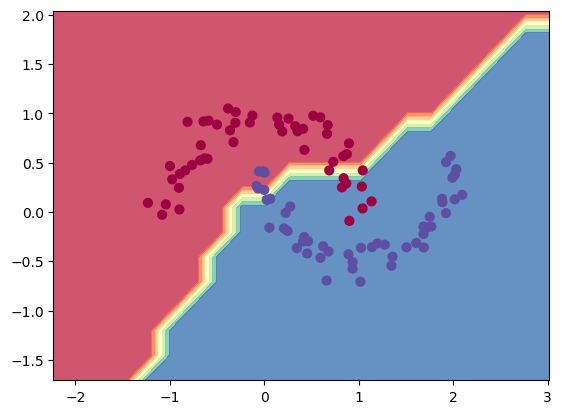

step 5 loss 0.3561756401322683, accuracy 83.0%


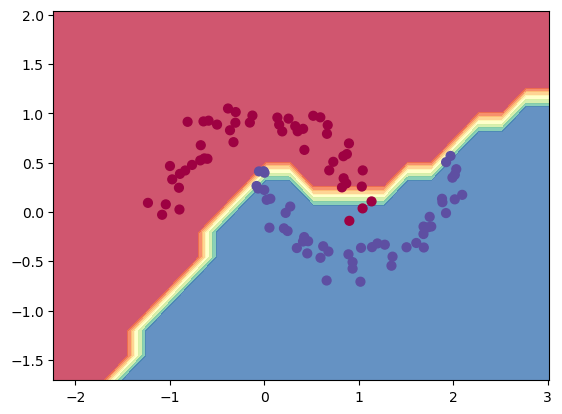

step 6 loss 0.2564069138131383, accuracy 87.0%


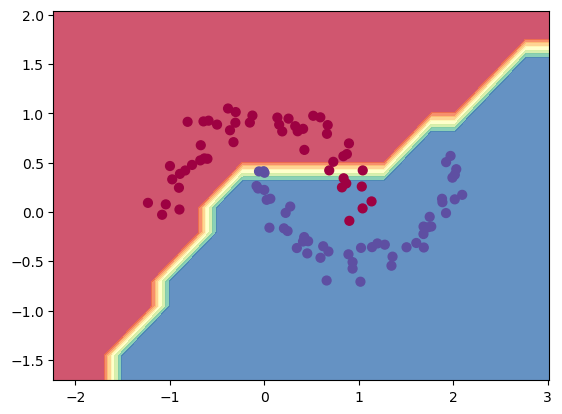

step 7 loss 0.1952865946770755, accuracy 94.0%


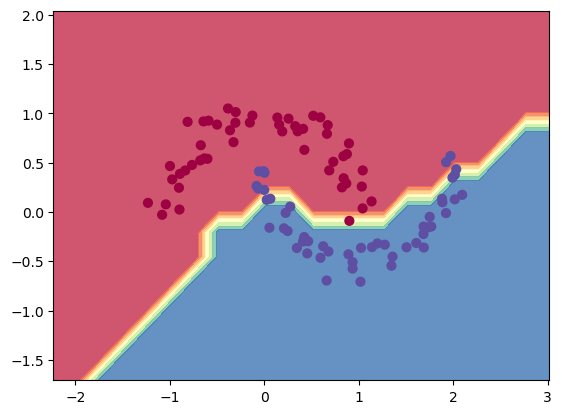

step 8 loss 0.19482643251197668, accuracy 93.0%


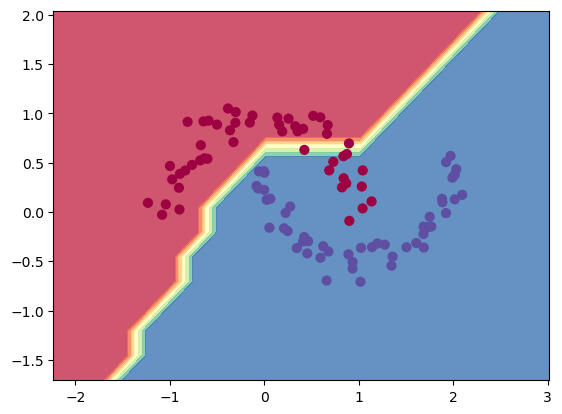

step 9 loss 0.2670493675246308, accuracy 89.0%


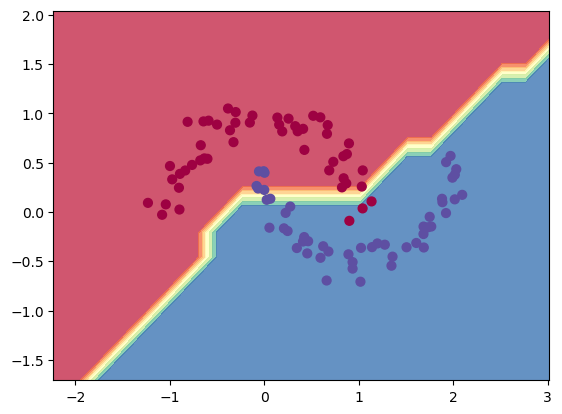

step 10 loss 0.26349841901834664, accuracy 88.0%


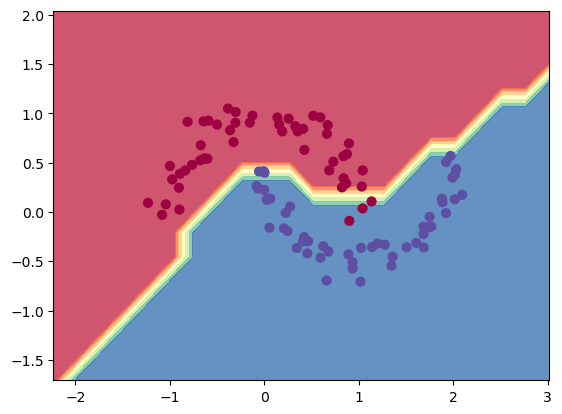

step 11 loss 0.1832337338147208, accuracy 92.0%


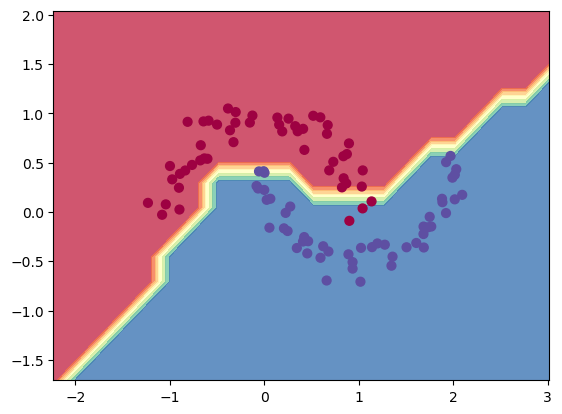

step 12 loss 0.12911933980287715, accuracy 95.0%


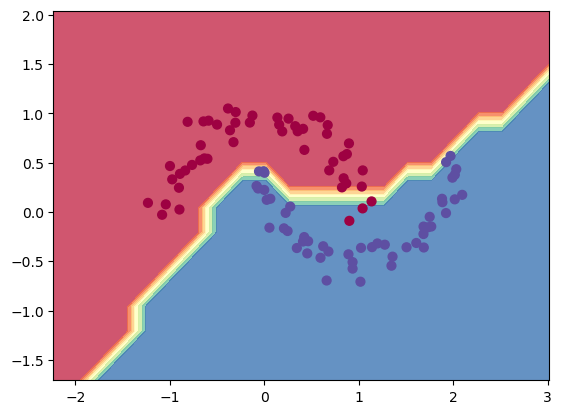

step 13 loss 0.12092701527926196, accuracy 97.0%


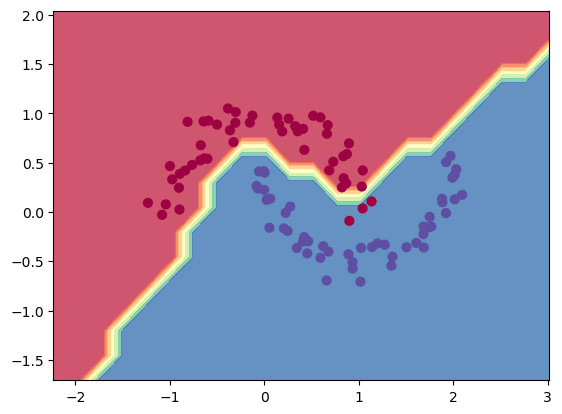

step 14 loss 0.12449570920393, accuracy 94.0%


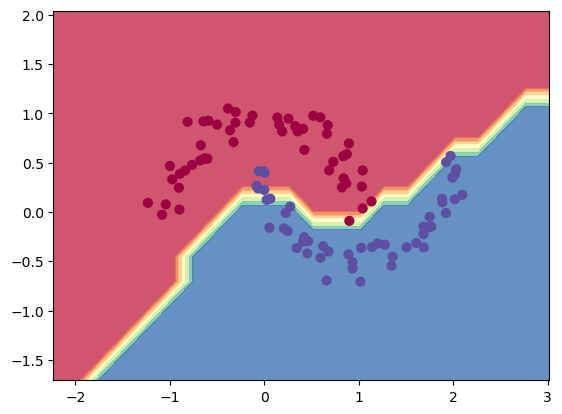

step 15 loss 0.12258580396311809, accuracy 97.0%


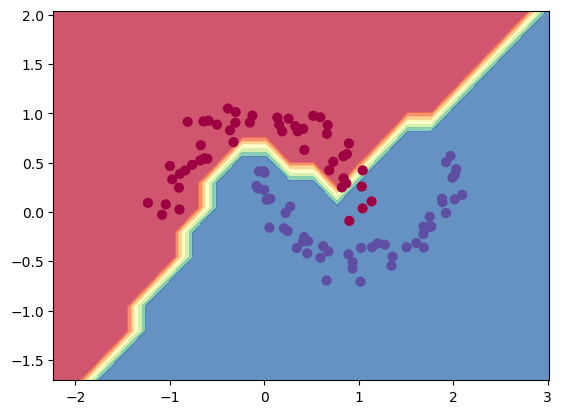

step 16 loss 0.15131872213193015, accuracy 94.0%


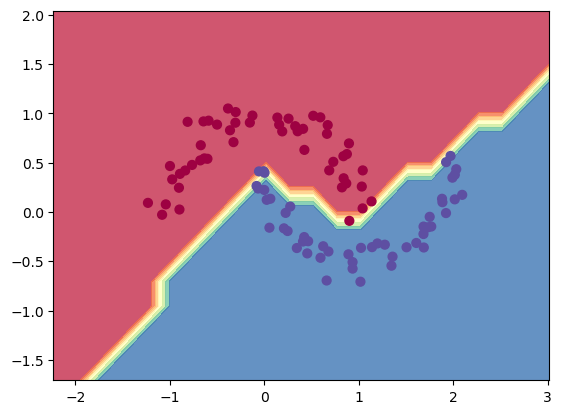

step 17 loss 0.14289491198313026, accuracy 94.0%


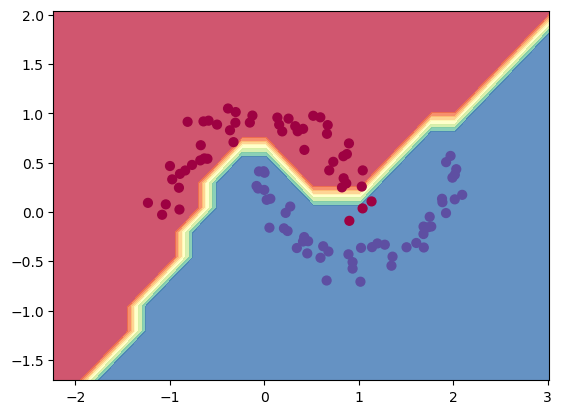

step 18 loss 0.11630675628494229, accuracy 96.0%


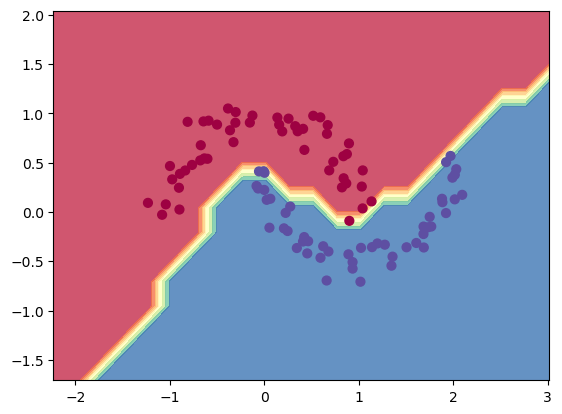

step 19 loss 0.09639212544692369, accuracy 97.0%


In [146]:
# optimization
lrs = []
for k in range(20):
    
    # forward
    total_loss, acc = loss()
    
    # backward
    model.zero_grad()
    total_loss.backward()
    
    # update (sgd)
    learning_rate = 1.0 - 0.9*k/100
    lrs.append(learning_rate)
    for p in model.parameters():
        p.data -= learning_rate * p.grad
    h = 0.25
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),np.arange(y_min, y_max, h))
    Xmesh = np.c_[xx.ravel(), yy.ravel()]
    inputs = [list(map(Value, xrow)) for xrow in Xmesh]
    scores = list(map(model, inputs))
    Z = np.array([s.data > 0 for s in scores])
    Z = Z.reshape(xx.shape)

    fig = plt.figure()
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.show()
    
    if k % 1 == 0:
        print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")

(-1.7071271642747874, 2.0428728357252126)

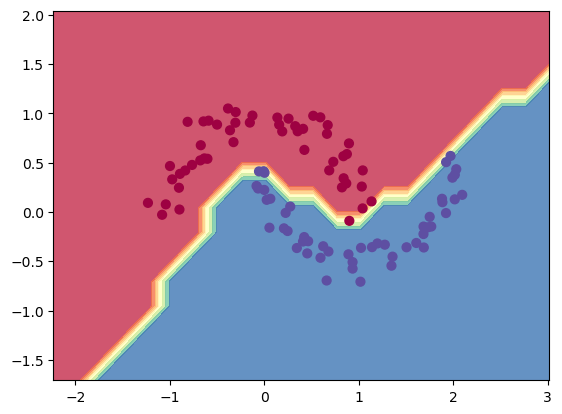

In [147]:
# visualize decision boundary

h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

In [148]:
l = []
for k in range(100):
    learning_rate = 1.0 - 0.9*k/100
    l.append(learning_rate)

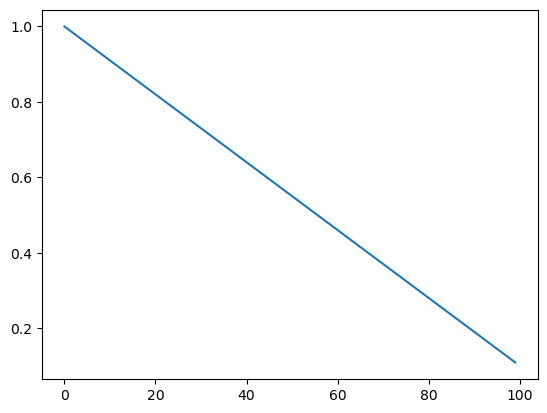

In [149]:
plt.plot(list(range(100)), l)